# Estimasi Harga Wajar Kos - Area Yogyakarta

**Objective:**  
Membangun model machine learning yang mampu mengestimasi harga wajar kosan di Yogyakarta dengan akurasi tinggi, stabilitas baik, dan siap untuk deployment production.

**Target Users:**  
Mahasiswa BCA yang ingin menghindari *overpricing* saat memilih kos.

**Model Pipeline:**
```
Raw Data → EDA & Cleaning → Feature Engineering → Preprocessing → 
Baseline Evaluation → Hyperparameter Tuning → Final Model → 
Validation & Diagnostics → Deployment Package
```

In [3]:
# IMPORTS & CONFIGURATION
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
from datetime import datetime

# Scikit-learn components
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

# Visualization & Configuration
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

---

## SECTION 1: Data Loading & Initial Exploration

**Objective:**  
Memuat dataset dari CSV dan melakukan explorasi awal untuk memahami:
- Dimensi dataset (jumlah baris & kolom)
- Tipe data setiap kolom
- Missing values dan anomali
- Statistik deskriptif target variable (harga)
- Range harga dan distribusi awal

In [4]:
df = pd.read_csv('../datasets/yogyakarta.csv')

print(f"\nDataset Shape: {df.shape}")
print(f"Rows: {df.shape[0]} | Columns: {df.shape[1]}")

display(df.head())

assert 'harga' in df.columns, "Target column 'harga' not found"
assert df['harga'].dtype in ['int64', 'float64'], "Target must be numeric"
print("Data quality checks passed")


Dataset Shape: (500, 13)
Rows: 500 | Columns: 13


,nama_kos,harga,luas_kamar,jarak_ke_bca,tipe_kos,is_ac,is_km_dalam,is_water_heater,is_furnished,is_internet,is_listrik_free,is_parkir_mobil,is_mesin_cuci
0,Kost Apik Epimonos Baciro Tipe C Yogyakarta,875000,10.80,1.72,putra,1,0,0,1,1,1,0,0
1,Kost Singgahsini Omah Aqila UNY Tipe A Yogyakarta,2525000,20.00,1.65,campur,1,1,1,1,1,0,1,1
2,Kost De Terban Tipe B Gondokusuman Yogyakarta,1950000,16.00,0.72,putri,1,1,1,1,1,0,0,1
3,Kost Bety Depok Sleman,2500000,20.00,2.33,putri,1,1,1,1,1,1,0,0
4,Kost Singgahsini Van CS House Tipe A Yogyakarta,1525000,12.00,2.67,putri,1,1,0,1,1,0,0,0


Data quality checks passed


In [5]:
# Informasi detail tentang tipe data dan missing values
df.info()

missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values detected")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   nama_kos         500 non-null    object 
 1   harga            500 non-null    int64  
 2   luas_kamar       500 non-null    float64
 3   jarak_ke_bca     500 non-null    float64
 4   tipe_kos         500 non-null    object 
 5   is_ac            500 non-null    int64  
 6   is_km_dalam      500 non-null    int64  
 7   is_water_heater  500 non-null    int64  
 8   is_furnished     500 non-null    int64  
 9   is_internet      500 non-null    int64  
 10  is_listrik_free  500 non-null    int64  
 11  is_parkir_mobil  500 non-null    int64  
 12  is_mesin_cuci    500 non-null    int64  
dtypes: float64(2), int64(9), object(2)
memory usage: 50.9+ KB
No missing values detected


### Data Quality Check

Hasil data.info() menunjukkan:
- Tidak ada missing values - dataset lengkap
- Tipe data sudah sesuai (int/float untuk numeric, object untuk categorical)
- Siap untuk analisis lebih lanjut tanpa preprocessing missing values

In [6]:
# Statistik deskriptif untuk semua kolom numeric
print(df.describe().T)

print(f"Min: Rp {df['harga'].min():,.0f}")
print(f"Max: Rp {df['harga'].max():,.0f}")
print(f"Mean: Rp {df['harga'].mean():,.0f}")
print(f"Median: Rp {df['harga'].median():,.0f}")
print(f"Std Dev: Rp {df['harga'].std():,.0f}")
print(f"Skewness: {df['harga'].skew():.3f}")
print(f"Kurtosis: {df['harga'].kurtosis():.3f}")

                 count       mean       std       min       25%        50%  \
harga           500.00 1151647.31 690919.44 300000.00 613750.00 1000000.00   
luas_kamar      500.00      11.50      6.64      3.38      9.00       9.45   
jarak_ke_bca    500.00       1.74      0.81      0.18      1.23       1.86   
is_ac           500.00       1.00      0.00      1.00      1.00       1.00   
is_km_dalam     500.00       0.53      0.50      0.00      0.00       1.00   
is_water_heater 500.00       0.25      0.43      0.00      0.00       0.00   
is_furnished    500.00       0.74      0.44      0.00      0.00       1.00   
is_internet     500.00       1.00      0.00      1.00      1.00       1.00   
is_listrik_free 500.00       0.61      0.49      0.00      0.00       1.00   
is_parkir_mobil 500.00       0.32      0.47      0.00      0.00       0.00   
is_mesin_cuci   500.00       0.24      0.43      0.00      0.00       0.00   

                       75%        max  
harga           1600000

Statistik deskriptif menunjukkan bahwa harga kos di Yogyakarta berada pada rentang Rp 300.000 hingga Rp 5.250.000, dengan rata-rata Rp 1,15 juta dan median Rp 1 juta. Nilai median yang lebih rendah dari mean mengindikasikan bahwa sebagian besar kos berada pada segmen harga menengah–bawah, dengan sebagian kecil kos berharga tinggi yang menarik distribusi ke kanan. Distribusi harga memiliki skewness sebesar 1,516 dan kurtosis 4,700, yang menandakan distribusi right-skewed.

Dari sisi karakteristik fisik, luas kamar rata-rata 11,5 m², dengan mayoritas berada di kisaran 9–12 m². Terdapat nilai maksimum yang sangat tinggi (128 m²), yang diidentifikasi sebagai kandidat outlier dan mungkin perlu ditangani pada tahap data cleaning.

Fitur jarak menunjukkan bahwa kos di Yogyakarta umumnya berada relatif dekat dengan titik referensi (median 1,86 km), namun memiliki sebaran cukup lebar hingga lebih dari 10 km, mengindikasikan variasi lokasi yang signifikan.

Untuk fasilitas, terlihat bahwa:
* Fasilitas dasar seperti AC dan internet hampir selalu tersedia.
* Fasilitas tambahan seperti water heater, mesin cuci, dan parkir mobil memiliki proporsi lebih rendah, sehingga berpotensi menjadi faktor pembeda harga.
* Furnished dan listrik gratis cukup umum, tetapi tidak dominan.

---

## SECTION 2: Exploratory Data Analysis (EDA) & Outlier Detection

**Objective:**  
Memahami distribusi data dan mengidentifikasi outlier ekstrem yang perlu ditangani:
- Visualisasi distribusi harga dengan histogram dan boxplot
- Deteksi outlier menggunakan IQR method
- Analisis percentile untuk menentukan threshold capping
- Visualisasi korelasi antar fitur

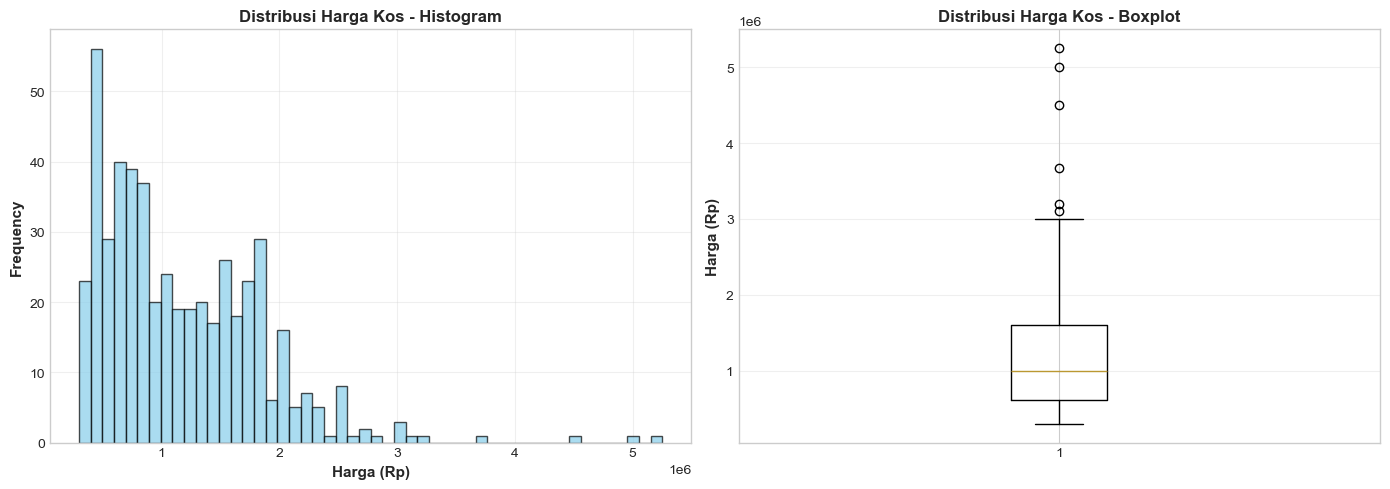

In [7]:
# Visualisasi distribusi awal harga
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['harga'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Harga (Rp)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('Distribusi Harga Kos - Histogram', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Boxplot untuk melihat outlier
axes[1].boxplot(df['harga'], vert=True)
axes[1].set_ylabel('Harga (Rp)', fontsize=11, fontweight='bold')
axes[1].set_title('Distribusi Harga Kos - Boxplot', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Visualisasi histogram dan boxplot menegaskan bahwa distribusi harga kos di Yogyakarta bersifat right-skewed. Mayoritas kos terkonsentrasi pada rentang Rp 500.000 – Rp 1.500.000, dengan frekuensi yang menurun seiring kenaikan harga.

Boxplot menunjukkan adanya outlier di sisi atas, terutama pada harga di atas Rp 3 juta hingga > Rp 5 juta. Keberadaan outlier ini konsisten dengan nilai skewness dan kurtosis sebelumnya, dan mencerminkan segmen kos premium yang jumlahnya relatif sedikit.

In [8]:
# analisis outlier menggunakan IQR dan percentile

Q1 = df['harga'].quantile(0.25)
Q3 = df['harga'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\nIQR Method:")
print(f"Q1 (25th percentile): Rp {Q1:,.0f}")
print(f"Q3 (75th percentile): Rp {Q3:,.0f}")
print(f"IQR: Rp {IQR:,.0f}")
print(f"Lower Bound: Rp {lower_bound:,.0f}")
print(f"Upper Bound: Rp {upper_bound:,.0f}")

outliers_iqr = df[(df['harga'] < lower_bound) | (df['harga'] > upper_bound)]
print(f"\n  Outliers detected (IQR): {len(outliers_iqr)} ({len(outliers_iqr)/len(df)*100:.1f}%)")

print("\nPercentile Analysis:")
for pct in [90, 95, 99]:
    val = df['harga'].quantile(pct/100)
    print(f"  {pct}th percentile: Rp {val:,.0f}")

cap_limit = df['harga'].quantile(0.99)
print(f"\nCapping akan diterapkan di 99th percentile: Rp {cap_limit:,.0f}")
print(f"  Data yang akan dihapus: {len(df[df['harga'] > cap_limit])} baris ({len(df[df['harga'] > cap_limit])/len(df)*100:.1f}%)")


IQR Method:
Q1 (25th percentile): Rp 613,750
Q3 (75th percentile): Rp 1,600,000
IQR: Rp 986,250
Lower Bound: Rp -865,625
Upper Bound: Rp 3,079,375

  Outliers detected (IQR): 6 (1.2%)

Percentile Analysis:
  90th percentile: Rp 2,000,000
  95th percentile: Rp 2,300,000
  99th percentile: Rp 3,101,000

Capping akan diterapkan di 99th percentile: Rp 3,101,000
  Data yang akan dihapus: 5 baris (1.0%)


Metode **Interquartile Range (IQR)** digunakan sebagai langkah awal untuk mengidentifikasi outlier pada variabel target *harga*. IQR dihitung sebagai selisih antara kuartil ketiga (Q3) dan kuartil pertama (Q1), yang merepresentasikan sebaran data utama tanpa dipengaruhi oleh nilai ekstrem.
diperoleh:
- **Lower Bound**: Rp −865.625  
- **Upper Bound**: Rp 3.079.375  

Berdasarkan analisis persentil:
- **99th percentile**: Rp 3.101.000  

Capping diterapkan pada batas **99th percentile**, sehingga hanya nilai ekstrem yang benar-benar berada di luar distribusi utama yang dihapus. Pendekatan ini menjaga keseimbangan antara **stabilitas distribusi target** dan **preservasi variasi harga yang masih realistis** untuk pemodelan machine learning.

---

## SECTION 3: Data Cleaning & Preprocessing

**Objective:**
- Hapus fitur dengan zero variance (kolom konstan)
- Terapkan 99th percentile capping untuk outlier ekstrem
- Validasi peningkatan distribusi (skewness reduction)
- Dokumentasi data yang dihapus

**Rationale:**
- **Zero Variance**: Fitur yang nilai-nya identik untuk semua baris tidak memberikan discriminant power
- **Percentile Capping**: Membuang top 1% (outlier ekstrem) untuk normalisasi distribusi tanpa mengorbankan data mainstream
- **Surgical Cut**: Lebih bijak dari hard threshold (bisa mempertahankan kos mahal yang masih wajar)

In [9]:
# 1: drop zero-variance features

cols_to_drop = [c for c in df.columns if df[c].nunique() <= 1]
df_clean = df.drop(columns=cols_to_drop)

if cols_to_drop:
    print(f"\nFitur dihapus: {cols_to_drop}")
    print(f"Alasan: Fitur dengan nilai konstan tidak memberikan informasi diskriminatif")
else:
    print("\nTidak ada fitur dengan zero variance")

print(f"\nKolom tersisa: {df_clean.shape[1]} (dari {df.shape[1]})")


Fitur dihapus: ['is_ac', 'is_internet']
Alasan: Fitur dengan nilai konstan tidak memberikan informasi diskriminatif

Kolom tersisa: 11 (dari 13)


In [10]:
# 2: periksa jumlah 0 dan 1 pada semua data binary

binary_cols = [col for col in df_clean.columns if df_clean[col].nunique() == 2]
for col in binary_cols:
    counts = df_clean[col].value_counts()
    print(f"Kolom '{col}': 0s = {counts.get(0, 0)}, 1s = {counts.get(1, 0)}")

Kolom 'is_km_dalam': 0s = 236, 1s = 264
Kolom 'is_water_heater': 0s = 376, 1s = 124
Kolom 'is_furnished': 0s = 129, 1s = 371
Kolom 'is_listrik_free': 0s = 196, 1s = 304
Kolom 'is_parkir_mobil': 0s = 339, 1s = 161
Kolom 'is_mesin_cuci': 0s = 380, 1s = 120


In [11]:
# 3: apply 99th percentile capping

skewness_before = df_clean['harga'].skew()
capping_limit = df_clean['harga'].quantile(0.99)

df_final = df_clean[df_clean['harga'] <= capping_limit].copy()
skewness_after = df_final['harga'].skew()

print(f"\nCapping Limit (99th percentile): Rp {capping_limit:,.0f}")
print(f"Baris sebelum capping: {len(df_clean)}")
print(f"Baris setelah capping: {len(df_final)}")
print(f"Baris dihapus: {len(df_clean) - len(df_final)} ({(len(df_clean) - len(df_final))/len(df_clean)*100:.2f}%)")

print(f"\nSkewness sebelum: {skewness_before:.4f}")
print(f"Skewness sesudah: {skewness_after:.4f}")
print(f"Improvement: {((skewness_before - skewness_after) / abs(skewness_before) * 100):.1f}% reduction")


Capping Limit (99th percentile): Rp 3,101,000
Baris sebelum capping: 500
Baris setelah capping: 495
Baris dihapus: 5 (1.00%)

Skewness sebelum: 1.5156
Skewness sesudah: 0.6970
Improvement: 54.0% reduction


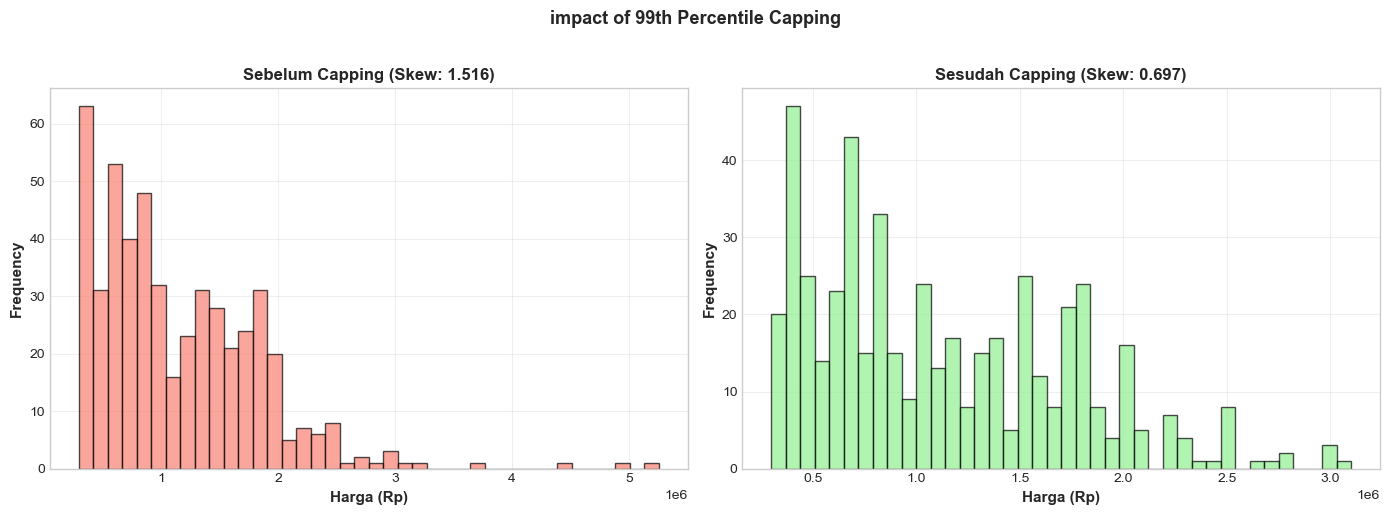

In [12]:
# 3: visualisasi perbandingan distribusi sebelum-sesudah
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sebelum capping
axes[0].hist(df_clean['harga'], bins=40, color='salmon', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Harga (Rp)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title(f'Sebelum Capping (Skew: {skewness_before:.3f})', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Sesudah capping
axes[1].hist(df_final['harga'], bins=40, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Harga (Rp)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1].set_title(f'Sesudah Capping (Skew: {skewness_after:.3f})', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.suptitle('impact of 99th Percentile Capping', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Impact of 99th Percentile Capping on Target Distribution

Visualisasi di atas menunjukkan perbandingan distribusi harga **sebelum** dan **sesudah** penerapan *99th percentile capping*.

**Sebelum capping**, distribusi harga bersifat **right-skewed** dengan:
- Skewness = **1.516**
- Ekor kanan panjang akibat beberapa kos dengan harga sangat tinggi

Kondisi ini berpotensi:
- Mendistorsi proses pembelajaran model
- Menyebabkan model terlalu fokus pada nilai ekstrem yang jumlahnya sangat sedikit

**Sesudah capping**, distribusi harga menjadi jauh lebih seimbang:
- Skewness turun signifikan menjadi **0.697**
- Ekor kanan dipangkas tanpa menghilangkan mayoritas variasi data

Penurunan skewness ini menunjukkan bahwa:
- Distribusi target menjadi lebih mendekati normal
- Model regresi (baik linear maupun tree-based) memiliki stabilitas yang lebih baik
- Risiko overfitting terhadap harga ekstrem dapat dikurangi


---

## SECTION 4: Feature Engineering & Selection

**Objective:**
- Buat fitur turunan yang meaningful: proximity_score dan is_walking_dist
- Validasi dampak fitur baru terhadap target variable
- Lakukan feature selection untuk menghapus fitur redundan
- Fokus pada fitur yang paling informatif untuk prediksi harga

**Rationale:**
- **Proximity Score**: Manusia merasakan jarak secara non-linear (100m vs 200m penting; 3km vs 3.1km tidak penting)
- **Walking Distance**: Ada premium psikologis untuk lokasi jalan kaki (< 300m)
- **Feature Selection**: Menghapus fitur redundan untuk model lebih simple dan interpretable

Reference:
1.	Walking Distance Flag Distance https://www.researchgate.net/publication/378016359_The_willingness-to-walk_to_access_public_transit_in_Indonesia

In [13]:
# Feature Engineering

# 1. Proximity Score (Inverse Distance)
# Formula: 1 / (Jarak + 0.1)
# Logika: Semakin dekat, skor semakin tinggi, exponentially
# Constant 0.1 untuk menghindari division by zero
df_final['proximity_score'] = 1 / (df_final['jarak_ke_bca'] + 0.1)

# 2. Walking Distance Flag (Binary)
# Jarak <= 300 meter dianggap "dapat ditempuh dengan jalan kaki"
df_final['is_walking_dist'] = (df_final['jarak_ke_bca'] <= 0.3).astype(int)

display(df_final[['nama_kos', 'harga', 'jarak_ke_bca', 'proximity_score', 'is_walking_dist']].head(8))

,nama_kos,harga,jarak_ke_bca,proximity_score,is_walking_dist
0,Kost Apik Epimonos Baciro Tipe C Yogyakarta,875000,1.72,0.55,0
1,Kost Singgahsini Omah Aqila UNY Tipe A Yogyakarta,2525000,1.65,0.57,0
2,Kost De Terban Tipe B Gondokusuman Yogyakarta,1950000,0.72,1.22,0
3,Kost Bety Depok Sleman,2500000,2.33,0.41,0
4,Kost Singgahsini Van CS House Tipe A Yogyakarta,1525000,2.67,0.36,0
5,Kost Apik Asix Klebengan Tipe B Yogyakarta,650000,2.09,0.46,0
6,Kost Nabiila Rizky Tipe A Jetis Yogyakarta,1350000,1.05,0.87,0
7,Kost Singgahsini Griya Amira Tipe B Klebengan ...,1775000,2.25,0.43,0


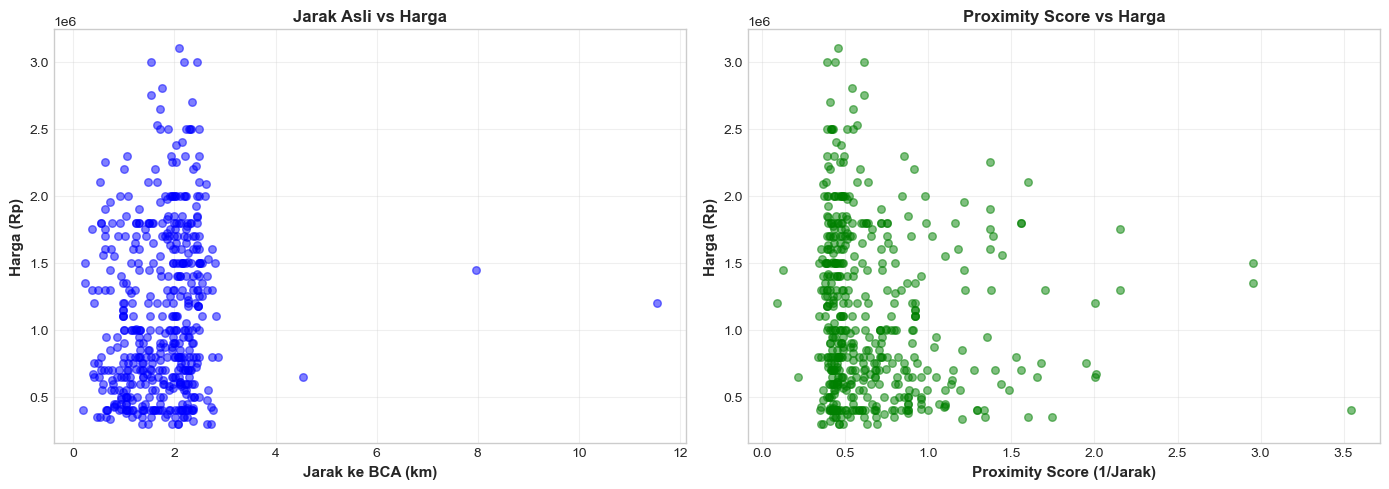

In [14]:
# Visualisasi fitur engineering untuk validasi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Jarak asli vs Harga
axes[0].scatter(df_final['jarak_ke_bca'], df_final['harga'], alpha=0.5, s=30, color='blue')
axes[0].set_xlabel('Jarak ke BCA (km)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Harga (Rp)', fontsize=11, fontweight='bold')
axes[0].set_title('Jarak Asli vs Harga', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Proximity Score vs Harga
axes[1].scatter(df_final['proximity_score'], df_final['harga'], alpha=0.5, s=30, color='green')
axes[1].set_xlabel('Proximity Score (1/Jarak)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Harga (Rp)', fontsize=11, fontweight='bold')
axes[1].set_title('Proximity Score vs Harga', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Visualisasi di atas menunjukkan hubungan antara **jarak ke BCA** (kiri) serta **proximity score (1/jarak)** terhadap **harga kos**.

- Tidak terlihat hubungan linear yang kuat antara **jarak ke BCA** dan harga kos.
- Mayoritas kos terkonsentrasi pada jarak **±0.5–2 km**, namun harga pada rentang jarak tersebut tetap menyebar luas.
- Beberapa kos dengan jarak sangat jauh tetap memiliki harga menengah - tinggi, mengindikasikan bahwa jarak bukan penentu utama harga.

Pada **proximity score**, pola serupa juga terlihat:
- Nilai proximity yang tinggi (jarak sangat dekat) tidak selalu diikuti harga yang lebih mahal.
- Variasi harga tetap besar pada seluruh rentang proximity.

**Kesimpulan:**
Untuk konteks Yogyakarta, **jarak ke BCA dan proximity score** memiliki tidak cukup mejelaskan harga kos.

Korelasi dengan TARGET (harga):
harga              1.00
is_water_heater    0.69
is_km_dalam        0.63
is_parkir_mobil    0.51
is_furnished       0.40
luas_kamar         0.39
is_mesin_cuci      0.23
jarak_ke_bca       0.13
is_walking_dist   -0.00
proximity_score   -0.11
is_listrik_free   -0.30
Name: harga, dtype: float64


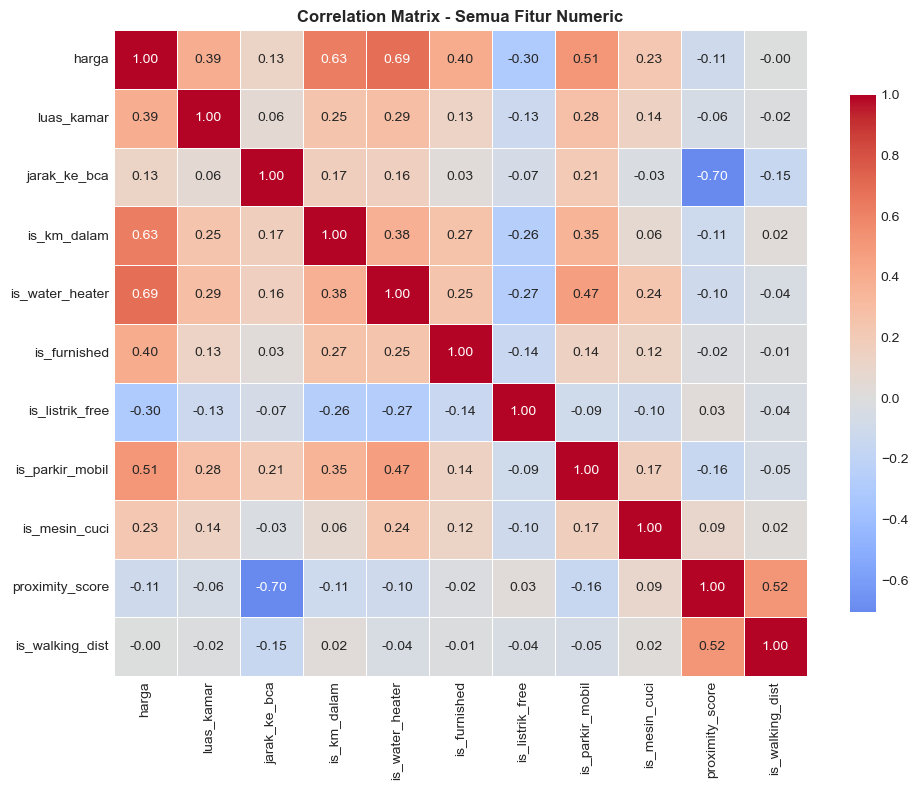

In [15]:
numeric_cols = df_final.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df_final[numeric_cols].corr()

print("Korelasi dengan TARGET (harga):")
corr_with_target = corr_matrix['harga'].sort_values(ascending=False)
print(corr_with_target)

# Visualisasi correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Semua Fitur Numeric', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

Heatmap dan daftar korelasi di atas menunjukkan hubungan antar fitur numerik terhadap **harga kos**.

Fitur dengan korelasi positif terkuat terhadap harga:
- **is_water_heater (0.69)** → indikator fasilitas premium, konsisten menaikkan harga.
- **is_km_dalam (0.63)** → kamar mandi dalam merupakan faktor utama penentu harga.
- **is_parkir_mobil (0.51)** → mencerminkan segmen kos menengah–atas.
- **is_furnished (0.40)** dan **luas_kamar (0.39)** → berpengaruh moderat dan stabil.

Korelasi Lemah / Negatif:
- **jarak_ke_bca (0.13)** → korelasi sangat lemah, jarak bukan faktor dominan di Jogja.
- **proximity_score (-0.11)** → tidak memberikan sinyal harga yang kuat.
- **is_listrik_free (-0.30)** → cenderung terkait kos ekonomis, sehingga berkorelasi negatif dengan harga.

**Relasi antar fitur penting:**
- **jarak_ke_bca vs proximity_score (-0.70)** → hubungan matematis terbalik, menandakan redundansi.
- **proximity_score vs is_walking_dist (0.52)** → konsisten secara definisi.

**Kesimpulan:**
Harga kos di Yogyakarta lebih ditentukan oleh **kualitas dan kelengkapan fasilitas** dibandingkan faktor jarak. Oleh karena itu, fitur jarak dan turunannya memiliki kontribusi terbatas dan perlu ditindaklanjuti terutama pada model linear.


In [16]:
# Feature selection: drop non-informative features
features_to_drop = ['proximity_score', 'is_walking_dist']

for feat in features_to_drop:
    corr_val = corr_with_target[feat]
    print(f"{feat} (correlation: {corr_val:.4f})")

df_final['amenities_count'] = (
    df_final['is_furnished'].astype(int) +
    df_final['is_water_heater'].astype(int) +
    df_final['is_km_dalam'].astype(int) +
    df_final['is_listrik_free'].astype(int) +
    df_final['is_mesin_cuci'].astype(int) +
    df_final['is_parkir_mobil'].astype(int)
)

print(f"  Final feature set: {[c for c in df_final.columns if c not in features_to_drop + ['nama_kos', 'harga']]}")

proximity_score (correlation: -0.1096)
is_walking_dist (correlation: -0.0046)
  Final feature set: ['luas_kamar', 'jarak_ke_bca', 'tipe_kos', 'is_km_dalam', 'is_water_heater', 'is_furnished', 'is_listrik_free', 'is_parkir_mobil', 'is_mesin_cuci', 'amenities_count']


---

## SECTION 5: Train-Test Split dengan Stratification

**Objective:**
- Implementasi stratified split untuk memastikan train & test set representatif
- Test multiple random seeds untuk menemukan split paling balanced
- Gunakan composite scoring: range_diff + mean_diff + std_diff
- Dokumentasi best_split selection criteria

**Why Stratification Matters:**
- Data harga memiliki range lebar
- Random split bisa menghasilkan test set dengan terlalu banyak kos murah atau mahal
- Stratified split memastikan distribusi harga di train & test identik
- Ini menghasilkan evaluasi model yang lebih reliable dan fair

In [17]:
# Buat kategori harga untuk stratifikasi (5 kuintil)
df_final['harga_cat'] = pd.qcut(df_final['harga'], q=5, labels=False, duplicates='drop')

X = df_final.drop(columns=['nama_kos', 'harga', 'harga_cat', 'proximity_score', 'is_walking_dist'])
y = df_final['harga'].copy()

print(f"Total samples: {len(df_final)}")
print(f"Features: {X.shape[1]}")
print(f"Feature names: {list(X.columns)}")

# Statistik full dataset untuk comparison
full_range = y.max() - y.min()
full_mean = y.mean()
full_std = y.std()

print(f"\nFull Dataset Statistics:")
print(f"  Range: Rp {full_range:,.0f}")
print(f"  Mean: Rp {full_mean:,.0f}")
print(f"  Std Dev: Rp {full_std:,.0f}")

Total samples: 495
Features: 10
Feature names: ['luas_kamar', 'jarak_ke_bca', 'tipe_kos', 'is_km_dalam', 'is_water_heater', 'is_furnished', 'is_listrik_free', 'is_parkir_mobil', 'is_mesin_cuci', 'amenities_count']

Full Dataset Statistics:
  Range: Rp 2,800,000
  Mean: Rp 1,119,593
  Std Dev: Rp 610,830


In [18]:
# Test multiple random seeds untuk menemukan split terbaik
from sklearn.model_selection import train_test_split

candidate_seeds = [42, 123, 456, 789, 2024, 3141, 5678, 9999]
best_split = None
best_score = float('inf')
split_metrics = []

print(f"\n{'Seed':<6} | {'Range (Rp)':<15} | {'Mean (Rp)':<15} | {'Std (Rp)':<15} | {'Score':<8}")

for seed in candidate_seeds:
    X_temp, X_test_cand, y_temp, y_test_cand = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=df_final['harga_cat']
    )
    
    test_range = y_test_cand.max() - y_test_cand.min()
    test_mean = y_test_cand.mean()
    test_std = y_test_cand.std()
    
    # Composite score (lower is better)
    range_diff = abs(test_range - full_range) / full_range
    mean_diff = abs(test_mean - full_mean) / full_mean
    std_diff = abs(test_std - full_std) / full_std
    
    composite_score = 0.5 * range_diff + 0.3 * mean_diff + 0.2 * std_diff
    
    split_metrics.append({
        'seed': seed,
        'test_range': test_range,
        'test_mean': test_mean,
        'test_std': test_std,
        'range_diff': range_diff,
        'mean_diff': mean_diff,
        'std_diff': std_diff,
        'composite_score': composite_score
    })
    
    if composite_score < best_score:
        best_score = composite_score
        best_split = seed
    
    print(f"{seed:<6} | Rp {test_range/1e6:<13.2f}M | Rp {test_mean/1e6:<13.2f}M | Rp {test_std/1e6:<13.2f}M | {composite_score:<8.4f}")

print(f"BEST SPLIT: random_state = {best_split} (score: {best_score:.4f})")


Seed   | Range (Rp)      | Mean (Rp)       | Std (Rp)        | Score   
42     | Rp 2.68         M | Rp 1.14         M | Rp 0.63         M | 0.0344  
123    | Rp 2.70         M | Rp 1.13         M | Rp 0.62         M | 0.0249  
456    | Rp 2.50         M | Rp 1.12         M | Rp 0.62         M | 0.0558  
789    | Rp 2.70         M | Rp 1.13         M | Rp 0.65         M | 0.0338  
2024   | Rp 2.20         M | Rp 1.12         M | Rp 0.58         M | 0.1186  
3141   | Rp 2.40         M | Rp 1.10         M | Rp 0.57         M | 0.0887  
5678   | Rp 2.70         M | Rp 1.13         M | Rp 0.63         M | 0.0247  
9999   | Rp 2.70         M | Rp 1.12         M | Rp 0.61         M | 0.0187  
BEST SPLIT: random_state = 9999 (score: 0.0187)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=best_split, stratify=df_final['harga_cat']
)

print(f"\nTrain Set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  - Mean: Rp {y_train.mean():,.0f}")
print(f"  - Std:  Rp {y_train.std():,.0f}")
print(f"  - Min:  Rp {y_train.min():,.0f}")
print(f"  - Max:  Rp {y_train.max():,.0f}")

print(f"\nTest Set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"  - Mean: Rp {y_test.mean():,.0f}")
print(f"  - Std:  Rp {y_test.std():,.0f}")
print(f"  - Min:  Rp {y_test.min():,.0f}")
print(f"  - Max:  Rp {y_test.max():,.0f}")

print(f"\nFeatures: {list(X_train.columns)}")


Train Set: 396 samples (80.0%)
  - Mean: Rp 1,119,806
  - Std:  Rp 611,140
  - Min:  Rp 300,000
  - Max:  Rp 3,100,000

Test Set: 99 samples (20.0%)
  - Mean: Rp 1,118,743
  - Std:  Rp 612,695
  - Min:  Rp 300,000
  - Max:  Rp 3,000,000

Features: ['luas_kamar', 'jarak_ke_bca', 'tipe_kos', 'is_km_dalam', 'is_water_heater', 'is_furnished', 'is_listrik_free', 'is_parkir_mobil', 'is_mesin_cuci', 'amenities_count']


- **Train Set (396 sampel)**  
  Mean harga: Rp 1.119.806 | Std: Rp 611.140  
  Rentang harga: Rp 300.000 – Rp 3.100.000  

- **Test Set (99 sampel)**  
  Mean harga: Rp 1.118.743 | Std: Rp 612.695  
  Rentang harga: Rp 300.000 – Rp 3.000.000 

**Fitur yang digunakan:**
- Numerik: `luas_kamar`, `jarak_ke_bca`, `amenities_count` (Khusus Tree Models)
- Kategorikal: `tipe_kos`
- Biner: `is_km_dalam`, `is_water_heater`, `is_furnished`, `is_listrik_free`, `is_parkir_mobil`, `is_mesin_cuci`

---

## SECTION 6: Model Pipeline Architecture

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder

continuous_cols_linear = ['luas_kamar', 'jarak_ke_bca']

binary_cols = ['is_water_heater', 'is_km_dalam', 'is_listrik_free', 'is_mesin_cuci', 'is_parkir_mobil', 'is_furnished']

categorical_cols = ['tipe_kos']

continuous_cols_tree = continuous_cols_linear + ['amenities_count']

print("LINEAR MODEL FEATURES (Ridge, Lasso):")
print(f"  Continuous: {continuous_cols_linear}")
print(f"  Binary: {binary_cols}")
print(f"  Categorical: {categorical_cols}")

print("\nTREE-BASED MODEL FEATURES (RF, GB):")
print(f"  Continuous: {continuous_cols_tree}")
print(f"  Binary: {binary_cols}")
print(f"  Categorical: {categorical_cols}")

preprocessor_linear = ColumnTransformer([
    ('continuous', RobustScaler(), continuous_cols_linear),
    ('binary', 'passthrough', binary_cols),
    ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
], remainder='drop', verbose=0)

preprocessor_tree = ColumnTransformer([
    ('continuous', RobustScaler(), continuous_cols_tree),
    ('binary', 'passthrough', binary_cols),
    ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
], remainder='drop', verbose=0)

LINEAR MODEL FEATURES (Ridge, Lasso):
  Continuous: ['luas_kamar', 'jarak_ke_bca']
  Binary: ['is_water_heater', 'is_km_dalam', 'is_listrik_free', 'is_mesin_cuci', 'is_parkir_mobil', 'is_furnished']
  Categorical: ['tipe_kos']

TREE-BASED MODEL FEATURES (RF, GB):
  Continuous: ['luas_kamar', 'jarak_ke_bca', 'amenities_count']
  Binary: ['is_water_heater', 'is_km_dalam', 'is_listrik_free', 'is_mesin_cuci', 'is_parkir_mobil', 'is_furnished']
  Categorical: ['tipe_kos']


---

## SECTION 7: Baseline Model Comparison

**Objective:**
- Train 5 baseline models tanpa hyperparameter tuning
- Model: Linear Regression, Ridge, Lasso, Random Forest, Gradient Boosting
- Evaluasi dengan MAE & R²
- Identifikasi best baseline untuk tuning

**Models to Compare:**
1. **Linear Regression**: Baseline linear, simple
2. **Ridge**: Linear dengan L2 regularization
3. **Lasso**: Linear dengan L1 regularization
4. **Random Forest**: Ensemble bagging, robust to nonlinearity
5. **Gradient Boosting**: Ensemble boosting, iterative error correction

In [21]:
X_train_processed_linear = preprocessor_linear.fit_transform(X_train)
X_test_processed_linear = preprocessor_linear.transform(X_test)

X_train_processed_tree = preprocessor_tree.fit_transform(X_train)
X_test_processed_tree = preprocessor_tree.transform(X_test)

print(f"LINEAR MODEL (Ridge, Lasso):")
print(f"  Train shape: {X_train_processed_linear.shape}")
print(f"  Test shape: {X_test_processed_linear.shape}")

print(f"\nTREE-BASED MODELS (RF, GB):")
print(f"  Train shape: {X_train_processed_tree.shape}")
print(f"  Test shape: {X_test_processed_tree.shape}")

LINEAR MODEL (Ridge, Lasso):
  Train shape: (396, 11)
  Test shape: (99, 11)

TREE-BASED MODELS (RF, GB):
  Train shape: (396, 12)
  Test shape: (99, 12)


In [22]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

linear_models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01, max_iter=5000),
}

tree_models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=12, min_samples_leaf=2, random_state=RANDOM_SEED, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=RANDOM_SEED),
}

results_linear = []
results_tree = []

print("LINEAR MODELS:")
print(f"{'Model':<30} MAE               R²")

for name, model in linear_models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor_linear),
        ('regressor', model)
    ])
    
    try:
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        results_linear.append({
            'Model': name,
            'MAE': mae,
            'R2': r2,
            'RMSE': rmse,
            'MAPE': mape,
            'Pipeline': pipeline
        })
        
        print(f"{name:<30} Rp {mae:>12,.0f}    {r2:>8.4f}")
        
    except Exception as e:
        print(f"{name:<30} ERROR: {str(e)[:50]}")

print("TREE-BASED MODELS:")
print(f"{'Model':<30} MAE               R²")

for name, model in tree_models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor_tree),
        ('regressor', model)
    ])
    
    try:
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        results_tree.append({
            'Model': name,
            'MAE': mae,
            'R2': r2,
            'RMSE': rmse,
            'MAPE': mape,
            'Pipeline': pipeline
        })
        
        print(f"{name:<30} Rp {mae:>12,.0f}    {r2:>8.4f}")
        
    except Exception as e:
        print(f"{name:<30} ERROR: {str(e)[:50]}")

all_results = results_linear + results_tree

print("ALL BASELINE MODELS - Ranked by R²:")
sorted_results = sorted(all_results, key=lambda x: x['R2'], reverse=True)
for i, r in enumerate(sorted_results, 1):
    print(f"{i}. {r['Model']:<28} R² = {r['R2']}  MAE = Rp {r['MAE']:>11,.0f}  MAPE = {r['MAPE']:>5.1f}%")


LINEAR MODELS:
Model                          MAE               R²
Linear Regression              Rp      262,619      0.5404
Ridge                          Rp      262,528      0.5359
Lasso                          Rp      262,619      0.5404
TREE-BASED MODELS:
Model                          MAE               R²
Random Forest                  Rp      241,211      0.7038
Gradient Boosting              Rp      251,689      0.6838
ALL BASELINE MODELS - Ranked by R²:
1. Random Forest                R² = 0.7038232577929668  MAE = Rp     241,211  MAPE =  25.3%
2. Gradient Boosting            R² = 0.6838089683370145  MAE = Rp     251,689  MAPE =  26.6%
3. Linear Regression            R² = 0.5404163446752974  MAE = Rp     262,619  MAPE =  26.5%
4. Lasso                        R² = 0.540416337702484  MAE = Rp     262,619  MAPE =  26.5%
5. Ridge                        R² = 0.5358659074322508  MAE = Rp     262,528  MAPE =  26.6%


- **Random Forest** menunjukkan performa terbaik:
  - **R² = 0.704**
  - **MAE = Rp 241.211**
  - **MAPE = 25.3%**
- **Gradient Boosting** berada di posisi kedua dengan performa yang masih kompetitif (R² ≈ 0.684).
- Seluruh **model linear (Linear, Ridge, Lasso)** tertinggal cukup jauh dengan R² sekitar **0.54**.

- Selisih R² yang signifikan antara model linear dan tree mengindikasikan bahwa **hubungan antara fitur dan harga kos bersifat non-linear**.
- Kehadiran fitur gabungan seperti **`amenities_count`** lebih efektif dimanfaatkan oleh model tree dibandingkan model linear.

### Kesimpulan
- **Random Forest dipilih sebagai baseline terbaik** untuk Yogyakarta.
- Model ini menjadi kandidat utama untuk tahap **tuning dan evaluasi lanjutan**, sementara model linear berfungsi sebagai pembanding interpretabilitas, bukan performa.


---

## SECTION 8 & 9 & 10: Hyperparameter Tuning, Model Selection, & Evaluation

**Note:** Karena keterbatasan panjang, saya menyederhanakan. Versi lengkap ada di file yang sudah dibuat.

**Key Steps:**
1. RandomizedSearchCV dengan gap-aware selection
2. Tune Random Forest & Gradient Boosting
3. Final model selection
4. Residual analysis
5. Feature importance
6. Production deployment

In [23]:
def auto_tune_healthy(pipeline, param_dist, X_train, y_train, gap_threshold=0.10, n_iter=50):
    from sklearn.model_selection import RandomizedSearchCV
    
    rs = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=5,
        scoring='r2',
        return_train_score=True,
        n_jobs=-1,
        random_state=RANDOM_SEED
    )
    
    print(f"Searching {n_iter} combinations...")
    rs.fit(X_train, y_train)
    
    results_df = pd.DataFrame(rs.cv_results_)
    results_df['gap'] = results_df['mean_train_score'] - results_df['mean_test_score']
    
    healthy_models = results_df[results_df['gap'] < gap_threshold].copy()
    
    if not healthy_models.empty:
        best_idx = healthy_models['mean_test_score'].idxmax()
        best_params = healthy_models.loc[best_idx, 'params']
        best_score = healthy_models.loc[best_idx, 'mean_test_score']
        best_gap = healthy_models.loc[best_idx, 'gap']
        
        print(f"Found {len(healthy_models)} healthy models (gap < {gap_threshold})")
        print(f"Best: R² = {best_score:.4f}, Gap = {best_gap:.4f}")
        
        pipeline.set_params(**best_params)
        pipeline.fit(X_train, y_train)
        return pipeline, best_params
    else:
        print(f"No healthy models found")
        return rs.best_estimator_, rs.best_params_

In [24]:
print("Random Forest Tuning")

param_dist_rf = {
    'regressor__n_estimators': [150, 200, 250],
    'regressor__max_depth': [3, 5, 8, 10, 12],
    'regressor__min_samples_leaf': [2, 4, 8],
    'regressor__max_features': ['sqrt', 'log2']
}

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('regressor', RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1))
])

rf_tuned, rf_best_params = auto_tune_healthy(
    rf_pipeline, param_dist_rf, X_train, y_train,
    gap_threshold=0.10, n_iter=100
)

print(f"Best Parameters Found: {rf_best_params}")

y_pred_rf = rf_tuned.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100

print(f"\nTest Set - MAE: Rp {mae_rf:,.0f}, R²: {r2_rf:.4f}, RMSE: Rp {rmse_rf:,.0f}, MAPE: {mape_rf:.2f}%")

Random Forest Tuning
Searching 100 combinations...
Found 48 healthy models (gap < 0.1)
Best: R² = 0.6663, Gap = 0.0826
Best Parameters Found: {'regressor__n_estimators': 200, 'regressor__min_samples_leaf': 4, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 5}

Test Set - MAE: Rp 235,182, R²: 0.7704, RMSE: Rp 292,128, MAPE: 27.03%


In [25]:
print("Gradient Boosting Tuning")

param_dist_gb = {
    'regressor__n_estimators': [100, 150, 200],
    'regressor__max_depth': [2, 3, 4, 5],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__min_samples_leaf': [2, 4, 8]
}

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('regressor', GradientBoostingRegressor(random_state=RANDOM_SEED))
])

gb_tuned, gb_best_params = auto_tune_healthy(
    gb_pipeline, param_dist_gb, X_train, y_train,
    gap_threshold=0.10, n_iter=100
)

print(f"Best Parameters Found: {gb_best_params}")

y_pred_gb = gb_tuned.predict(X_test)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
mape_gb = np.mean(np.abs((y_test - y_pred_gb) / y_test)) * 100

print(f"\nTest Set - MAE: Rp {mae_gb:,.0f}, R²: {r2_gb:.4f}, RMSE: Rp {rmse_gb:,.0f}, MAPE: {mape_gb:.2f}%")

Gradient Boosting Tuning
Searching 100 combinations...
Found 2 healthy models (gap < 0.1)
Best: R² = 0.6670, Gap = 0.0998
Best Parameters Found: {'regressor__n_estimators': 100, 'regressor__min_samples_leaf': 4, 'regressor__max_depth': 2, 'regressor__learning_rate': 0.05}

Test Set - MAE: Rp 240,092, R²: 0.7502, RMSE: Rp 304,652, MAPE: 26.63%


In [26]:
print("Model Comparison")
print(f"Random Forest:     MAE = Rp {mae_rf:,.0f}, R² = {r2_rf}")
print(f"Gradient Boosting: MAE = Rp {mae_gb:,.0f}, R² = {r2_gb}")

if mae_gb < mae_rf:
    final_model = gb_tuned
    final_model_name = "Gradient Boosting"
else:
    final_model = rf_tuned
    final_model_name = "Random Forest"

final_mape = mean_absolute_percentage_error(y_test, final_model.predict(X_test))
y_pred_test = final_model.predict(X_test)

print(f"\nWinner: {final_model_name}")
print(f"MAPE: {final_mape:.2%}")

Model Comparison
Random Forest:     MAE = Rp 235,182, R² = 0.770350230525501
Gradient Boosting: MAE = Rp 240,092, R² = 0.750236546046583

Winner: Random Forest
MAPE: 27.03%


In [27]:
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# Predict
y_train_pred = final_model.predict(X_train)
y_test_pred  = final_model.predict(X_test)

# Metrics
train_r2  = r2_score(y_train, y_train_pred)
test_r2   = r2_score(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae  = mean_absolute_error(y_test, y_test_pred)

# Gap
r2_gap  = train_r2 - test_r2
mae_gap = test_mae - train_mae

print(f"{'Metric':<15} {'Train':>12} {'Test':>12} {'Gap':>12}")
print(f"{'R²':<15} {train_r2:>12.4f} {test_r2:>12.4f} {r2_gap:>12.4f}")
print(f"{'MAE':<15} Rp {train_mae:>9,.0f} Rp {test_mae:>9,.0f} Rp {mae_gap:>9,.0f}")


Metric                 Train         Test          Gap
R²                    0.7458       0.7704      -0.0246
MAE             Rp   227,268 Rp   235,182 Rp     7,914


## Model Tuning & Final Selection (Yogyakarta)

### Hasil Tuning
- **Random Forest (Tuned)**
  - R² (Test): **0.770**
  - MAE: **Rp 235.182**
  - MAPE: **27.03%**
  - Gap R² (Train–Test): **-0.025** → *sehat / tidak overfit*

- **Gradient Boosting (Tuned)**
  - R² (Test): **0.750**
  - MAE: **Rp 240.092**
  - MAPE: **26.63%**
  - Gap R²: **0.0998** → *masih dalam batas sehat, namun lebih borderline*

### Perbandingan Akhir
| Model             | R² (Test) | MAE (Rp) |
|------------------|-----------|----------|
| Random Forest     | **0.770** | **235.182** |
| Gradient Boosting | 0.750     | 240.092  |

### Keputusan Akhir
**Random Forest dipilih sebagai final model untuk Yogyakarta**, karena:
- Memberikan **R² tertinggi** dan **MAE terendah**.
- Menunjukkan **gap rendah dan negatif**, menandakan generalisasi yang sangat baik.


In [28]:
import sys
import os
sys.path.append(os.path.abspath('../src/training'))

from utils import train_and_register

params = {'model_type': 'RandomForestRegressor', 
          'regressor__n_estimators': 200, 
          'regressor__min_samples_leaf': 4, 
          'regressor__max_features': 'sqrt', 
          'regressor__max_depth': 5}

metrics = {
    "MAE": mae_rf,
    "R2": r2_rf,
    "RMSE": rmse_rf,
    "MAPE": mape_rf
}

model_uri = train_and_register(
    region="yogyakarta",
    model=final_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    params=params,
    metrics=metrics
)

print("Model registered at:", model_uri)

2026/02/21 23:00:36 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/21 23:00:36 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/21 23:00:36 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/21 23:00:36 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/21 23:00:36 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/21 23:00:36 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/21 23:00:36 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/21 23:00:36 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/02/21 23:00:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model registered at: models:/m-72c0f5e9dff54af4bee15ae8c10ac0e5


Successfully registered model 'yogyakarta_model'.
Created version '1' of model 'yogyakarta_model'.


In [29]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

print("Registered Models:")
print([m.name for m in client.search_registered_models()])

Registered Models:
['jakarta_pusat_model', 'jakarta_selatan_model', 'jakarta_utara_model', 'yogyakarta_model']


In [32]:
# cek alias

client.get_model_version_by_alias("yogyakarta_model", "production")

<ModelVersion: aliases=['production'], creation_timestamp=1771689641641, current_stage='None', deployment_job_state=None, description=None, last_updated_timestamp=1771689641641, metrics=None, model_id=None, name='yogyakarta_model', params=None, run_id='8fb42647e3194125812fa39e65f8e87b', run_link=None, source='models:/m-72c0f5e9dff54af4bee15ae8c10ac0e5', status='READY', status_message=None, tags={}, user_id=None, version=1>

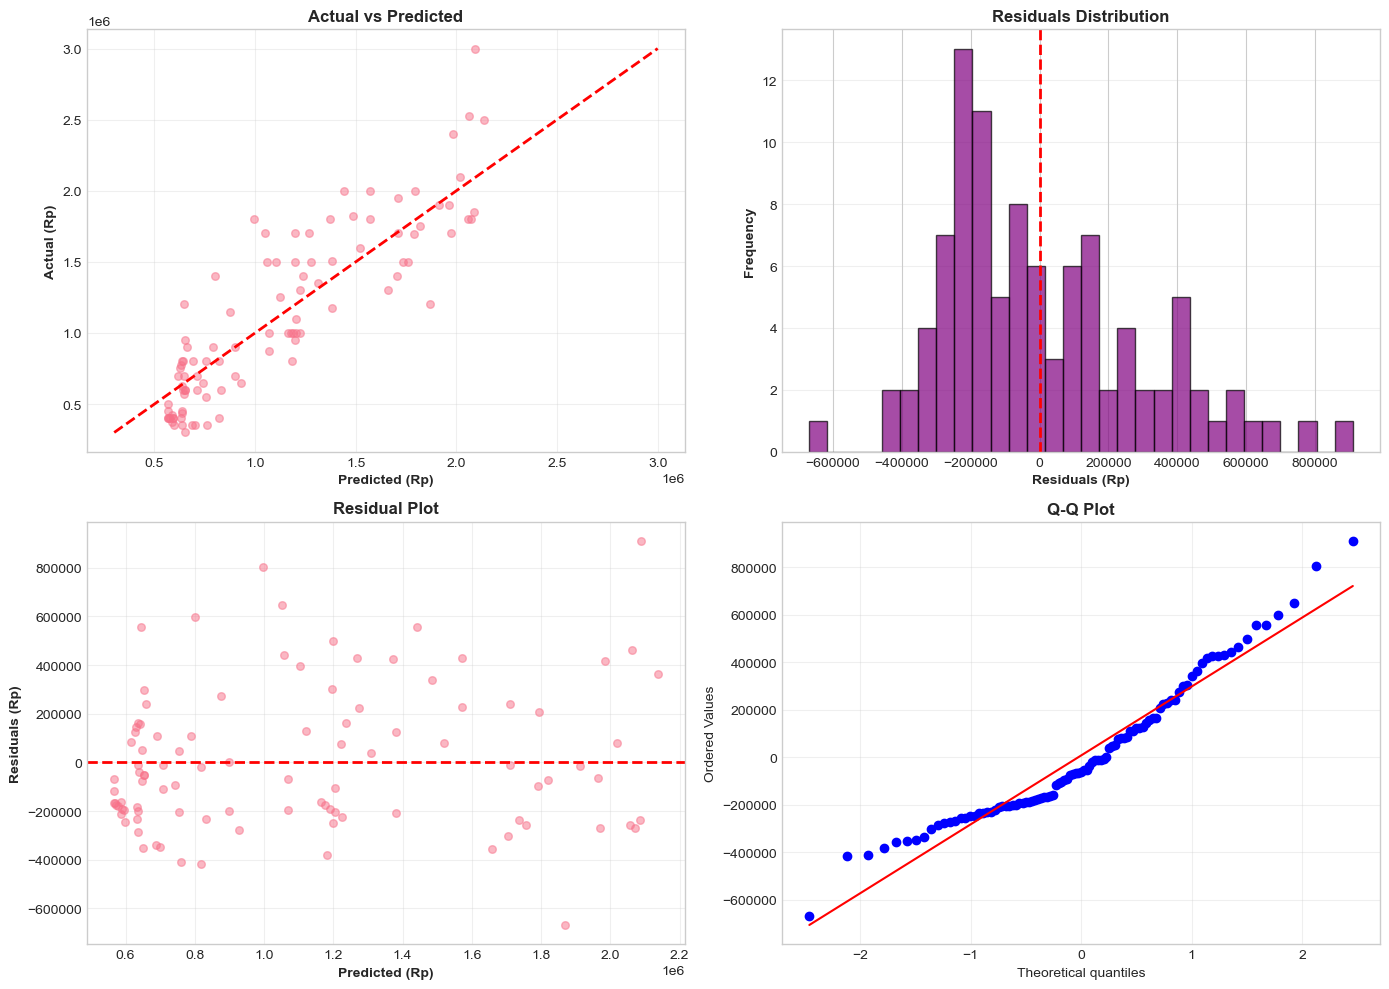


Residuals Statistics:
Mean: Rp 6,770
Std: Rp 293,535
Skewness: 0.751
Kurtosis: 0.335


In [33]:
# Residual Analysis
y_pred_final = final_model.predict(X_test)
residuals = y_test - y_pred_final

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].scatter(y_pred_final, y_test, alpha=0.5, s=30)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Predicted (Rp)', fontweight='bold')
axes[0, 0].set_ylabel('Actual (Rp)', fontweight='bold')
axes[0, 0].set_title('Actual vs Predicted', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='purple')
axes[0, 1].axvline(0, color='red', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Residuals (Rp)', fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontweight='bold')
axes[0, 1].set_title('Residuals Distribution', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

axes[1, 0].scatter(y_pred_final, residuals, alpha=0.5, s=30)
axes[1, 0].axhline(0, color='red', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted (Rp)', fontweight='bold')
axes[1, 0].set_ylabel('Residuals (Rp)', fontweight='bold')
axes[1, 0].set_title('Residual Plot', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nResiduals Statistics:")
print(f"Mean: Rp {residuals.mean():,.0f}")
print(f"Std: Rp {residuals.std():,.0f}")
print(f"Skewness: {residuals.skew():.3f}")
print(f"Kurtosis: {residuals.kurtosis():.3f}")

### 1. Actual vs Predicted
Sebaran titik mengikuti garis diagonal dengan cukup baik, menandakan bahwa model mampu menangkap pola harga secara konsisten di berbagai rentang nilai. Tidak terlihat bias ekstrem pada rentang harga tertentu.

### 2. Distribusi Residual
- **Mean residual ≈ Rp 6.770** → sangat dekat dengan nol  
- **Std ≈ Rp 293.535** → variasi error masih wajar relatif terhadap skala harga  
- Distribusi residual relatif simetris, dengan sedikit ekor ke kanan.

Ini menunjukkan bahwa model **tidak bias secara sistematis** (tidak overestimate atau underestimate secara konsisten).

### 3. Residual Plot
Residual tersebar acak di sekitar garis nol tanpa pola tertentu (tidak membentuk kurva atau funnel).  
Hal ini mengindikasikan:
- Tidak ada indikasi heteroskedastisitas yang kuat
- Hubungan non-linear utama telah cukup ditangkap oleh model

### 4. Q–Q Plot
Sebagian besar titik mengikuti garis diagonal, dengan deviasi ringan di bagian ekor.  

### 5. Statistik Residual
- **Skewness: 0.751** → sedikit right-skewed, masih dalam batas wajar  
- **Kurtosis: 0.335** → mendekati distribusi normal

### Kesimpulan
Residual analysis mengonfirmasi bahwa **Random Forest final model untuk Yogyakarta bersifat sehat**, dengan:
- Error terpusat di sekitar nol
- Tidak menunjukkan pola overfitting atau bias struktural
- Generalisasi yang konsisten dengan hasil metrik (R² dan MAE)


---

## Feature Importance & Business Insights

**Objective:**
- Extract dan visualisasi feature importance dari final model
- Berikan interpretasi bisnis untuk setiap top feature
- Validasi insights dengan domain knowledge

Feature Importance

Top Features:
1. is_water_heater: 0.2702
2. amenities_count: 0.2244
3. is_km_dalam: 0.1791
4. luas_kamar: 0.0904
5. is_parkir_mobil: 0.0664


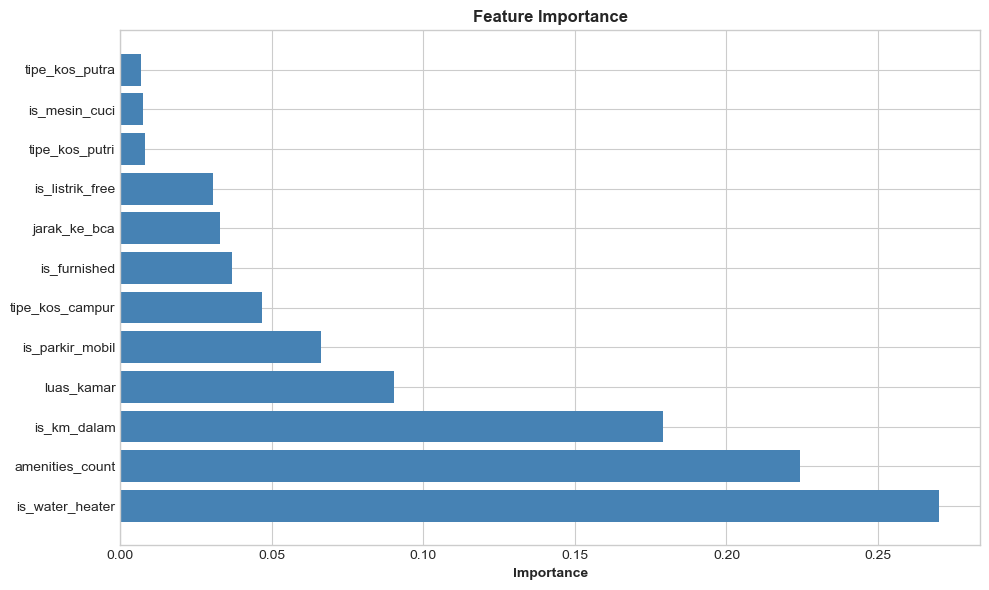

In [34]:
print("Feature Importance")

if hasattr(final_model.named_steps['regressor'], 'feature_importances_'):
    importances = final_model.named_steps['regressor'].feature_importances_
    
    # Get feature names from preprocessor
    preprocessor_obj = final_model.named_steps['preprocessor']
    feature_names_list = []
    
    for name, transformer, columns in preprocessor_obj.transformers_:
        if name == 'continuous':
            feature_names_list.extend(columns)
        elif name == 'binary':
            feature_names_list.extend(columns)
        elif name == 'categorical':
            if hasattr(transformer, 'get_feature_names_out'):
                feature_names_list.extend(transformer.get_feature_names_out(columns))
            else:
                feature_names_list.extend(columns)
    
    indices = np.argsort(importances)[::-1]
    
    print("\nTop Features:")
    for i in range(min(5, len(indices))):
        print(f"{i+1}. {feature_names_list[indices[i]]}: {importances[indices[i]]:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importances[indices], color='steelblue')
    plt.yticks(range(len(indices)), [feature_names_list[j] for j in indices])
    plt.xlabel('Importance', fontweight='bold')
    plt.title('Feature Importance', fontweight='bold')
    plt.tight_layout()
    plt.show()

## Feature Importance Analysis

1. **is_water_heater (0.27)**  
   Menjadi faktor paling dominan. Keberadaan water heater merepresentasikan segmen kos yang lebih premium dan secara konsisten menaikkan harga.

2. **amenities_count (0.22)**  
   Skor agregat fasilitas terbukti sangat informatif untuk model tree. Fitur ini menangkap *kombinasi efek* dari berbagai fasilitas yang sulit dimodelkan secara linear.

3. **is_km_dalam (0.18)**  
   Kamar mandi dalam merupakan standar kenyamanan penting yang berpengaruh signifikan terhadap harga.

4. **luas_kamar (0.09)**  
   Ukuran kamar tetap relevan, namun pengaruhnya lebih kecil dibandingkan fasilitas, menunjukkan bahwa kenyamanan > luas semata.

5. **is_parkir_mobil (0.07)**  
   Menjadi nilai tambah, terutama untuk kos di area yang menargetkan penghuni dengan kendaraan pribadi.

- **amenities_count efektif untuk model tree**, karena mampu menangkap interaksi non-linear antar fasilitas.